In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [5]:
def imshow(img, title=None):
    if title is not None:
        plt.title(title)
    plt.axis("off")
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.show()
    

In [6]:
videopath = "./videos/easy/gameplay1.mp4"


1920 1080


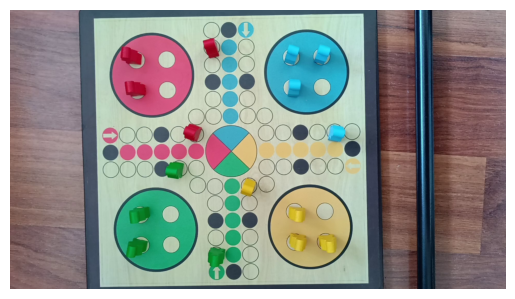

In [7]:
cap = cv2.VideoCapture(videopath)
if not cap.isOpened():
    raise Exception("Could not open")


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width, frame_height)
# 
fps = cap.get(cv2.CAP_PROP_FPS)
fps

_, frame = cap.read()
imshow(frame)



In [8]:
# cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# _, frame = cap.read()
# # frame = enhance(frame)
# c = (60,500)
# x = frame[c]
# # o = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
# cv2.circle(frame, c[::-1], 8, (255,0,0), 3)
# imshow(frame)
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# frame[c]

In [9]:
from enum import Enum

class Color(Enum):
    YELLOW = 1
    RED = 2
    GREEN = 3
    BLUE = 4


In [10]:
BGR ={
    Color.YELLOW: (0,255,255),
    Color.RED: (0,0,255),
    Color.GREEN: (0,255,0),
    Color.BLUE: (255,0,0),
}


In [11]:
def get_hsv_scale(lower_hsv, upper_hsv):
    width = upper_hsv[0] - lower_hsv[0]
    height = 100
    hsv_image = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(width):
        for j in range(height):
            hsv_value = [
                (lower_hsv[0] + i) % 180,  
                ((height - j) * upper_hsv[1] + lower_hsv[1] * j) // height, 
                upper_hsv[2]
            ]
            hsv_image[j, i] = hsv_value

    bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return bgr_image


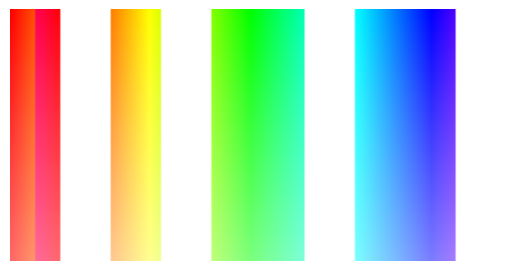

In [12]:
COLOR_RANGES = {
        Color.RED: [
            (np.array([0, 150, 70]), np.array([10, 255, 255])), 
            (np.array([170, 150, 70]), np.array([180, 255, 255]))
        ],
        Color.YELLOW: [
            (np.array([15, 110, 50]), np.array([35, 255, 255]))
        ],
        Color.GREEN: [
            (np.array([45, 130, 50]), np.array([82, 255, 255]))
        ],
        Color.BLUE: [
           (np.array([90, 130, 100]), np.array([130, 255, 255])) 
        ],
    }


scales = []
for ranges in COLOR_RANGES.values():
    for r in ranges:
        scales.append(get_hsv_scale(*r))
    scales.append(255*np.ones((100,20,3), dtype=np.uint8))
imshow(np.concatenate(scales,  1),)


In [13]:

def detect_dominant_color(image_fragment) -> Color:
    hsv = cv2.cvtColor(image_fragment, cv2.COLOR_BGR2HSV)
    
    
    color_counts = {color: 0 for color in COLOR_RANGES.keys()}
    for color, ranges in COLOR_RANGES.items():
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_counts[color] += cv2.countNonZero(mask)
    dominant_color = max(color_counts, key=color_counts.get)
    
    return dominant_color


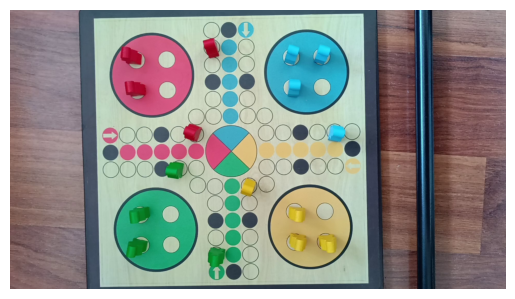

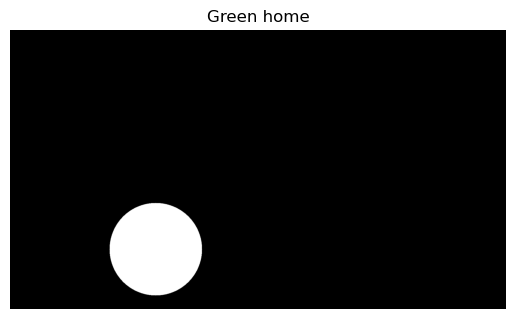

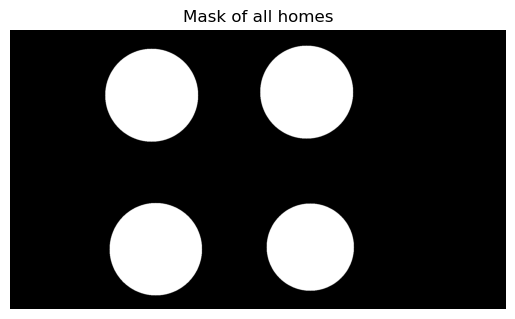

In [14]:
def get_home_masks(frame_gray):
    assert len(frame.shape) == 3, "frame must be BGR"   
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.medianBlur(frame_gray, 5)
    circles = cv2.HoughCircles(
        frame_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 1,
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 50,
        param2 = 30,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.25),
    )

    homes = {
                 Color.RED: dict(center = None, radius = None, mask=None),      
                 Color.BLUE: dict(center = None, radius = None, mask=None),
                 Color.GREEN:  dict(center = None, radius = None, mask=None),
                 Color.YELLOW: dict(center = None, radius = None, mask=None),
        }
                 
        
    circles = np.uint16(np.around(circles))
    for ((x,y,r), color) in zip(circles[0,:], homes):
        mask =   np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
        cv2.circle(mask ,(x,y),int(1.1*r),(255,255,255),-1)
        color = detect_dominant_color(frame & mask)
        homes[color]["center"] = (x,y)
        homes[color]["radius"] = r
        homes[color]["mask"] = mask

    return homes

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
homes = get_home_masks(frame)
imshow(frame)
imshow(homes[Color.GREEN]["mask"], title="Green home")
all_homes_mask = homes[Color.GREEN]["mask"] | homes [Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]
imshow(all_homes_mask, title="Mask of all homes")

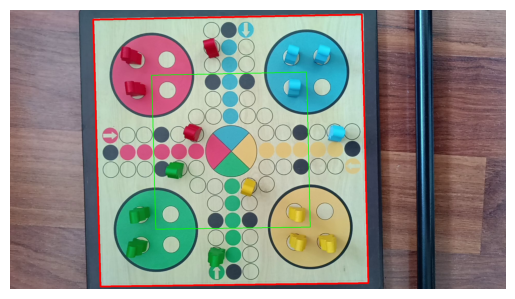

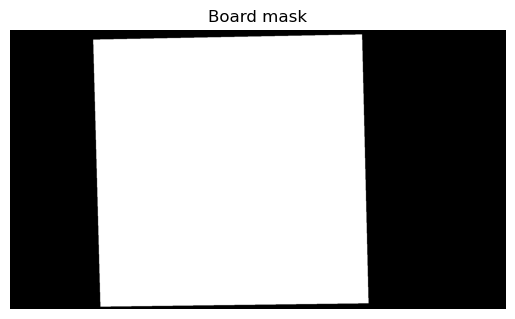

In [15]:
def get_board_mask_from_homes(frame, homes, verbose = False):
    
    corners = sorted([home["center"] for home in homes.values()], key = lambda x: x[1])
    top_points = corners[:2]
    bottom_points = corners[2:]
    
    top_left, top_right = sorted(top_points, key=lambda x: x[0])
    bottom_left, bottom_right = sorted(bottom_points, key=lambda x: x[0])

    contour = np.array([top_left, top_right, bottom_right, bottom_left],dtype=np.int32)
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        raise ValueError("Something wrong with home centers")

    home_dist_to_board_len_ratio = 26.0 / 15.0
    
    scaled_contour = []
    for point in contour:
        x, y = point
        # Scale the point relative to the centroid
        new_x = cx + home_dist_to_board_len_ratio * (x - cx)
        new_y = cy + home_dist_to_board_len_ratio * (y - cy)
        scaled_contour.append([[int(new_x), int(new_y)]])
        
    scaled_contour = np.array(scaled_contour, dtype=np.int32)
    # print(contour.shape)
    if verbose:
        output_image = frame.copy()
        cv2.drawContours(output_image, [contour], -1, (0,255,0),2)
        cv2.drawContours(output_image, [scaled_contour], -1, (0,0,255),5)
        imshow(output_image)

    board_mask = np.zeros_like(frame)
    cv2.drawContours(board_mask, [scaled_contour], -1, (255,255,255),-1)
    return board_mask

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
board_mask = get_board_mask_from_homes(frame, homes, verbose=True)
# if board_mask == None:
#     board_mask = np.ones_like(frame, dtype=np.uint8) * 255
# homes
imshow(board_mask, "Board mask")


dict_keys(['center', <Color.RED: 2>, <Color.BLUE: 4>, <Color.GREEN: 3>, <Color.YELLOW: 1>])


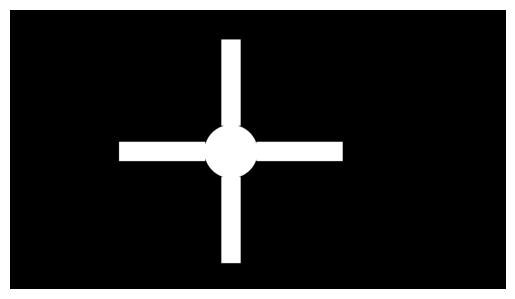

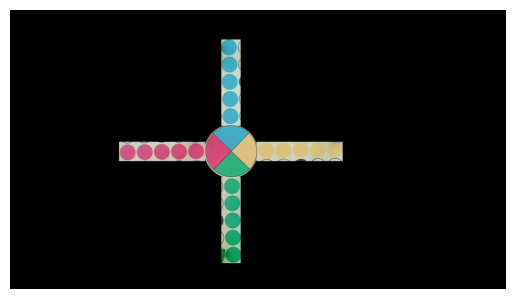

In [16]:
def get_target_bases(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(
            frame_gray,
            method = cv2.HOUGH_GRADIENT,
            dp = 2,
            minDist = int(min(frame_height, frame_width)),
            param1 = 100,
            param2=100,
            minRadius=int(min(frame_height, frame_width) * 0.055),
            maxRadius=int(min(frame_height, frame_width) * 0.1),
        )
    circles = np.uint16(np.around(circles))
    assert len(circles) == 1
    (x,y,r) = circles[0][0]
    targets = dict()
    

    center_circle_mask = np.zeros_like(frame)  
    cv2.circle(center_circle_mask ,(x,y),int(r*1.05),(255,255,255),-1)
    targets["center"] = center_circle_mask
    
    target_base_thickness = int(min(frame_height, frame_width) * 0.07)
    target_base_length = int(min(frame_height, frame_width) * 0.31)
    
    left_target_x = x-r-target_base_length
    left_target_y = y-target_base_thickness//2
    
    up_target_x = x - target_base_thickness//2
    up_target_y = y - r - target_base_length
    
    down_target_x = x - target_base_thickness//2
    down_target_y = y + r
    
    right_target_x = x + r
    right_target_y = y - target_base_thickness//2
    
    
    empty_mask = np.zeros_like(frame)  
    left_target_mask = cv2.rectangle(empty_mask, (left_target_x, left_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & left_target_mask)
    targets[color] = left_target_mask
    
    empty_mask = np.zeros_like(frame)
    up_target_mask = cv2.rectangle(empty_mask, (up_target_x, up_target_y, target_base_thickness, target_base_length ), (255,255,255), -1)
    color = detect_dominant_color(frame & up_target_mask)
    targets[color] = up_target_mask
    
    empty_mask = np.zeros_like(frame)
    down_target_mask = cv2.rectangle(empty_mask, (down_target_x, down_target_y, target_base_thickness, target_base_length), (255,255,255), -1)
    color = detect_dominant_color(frame & down_target_mask)
    targets[color] = down_target_mask
    
    empty_mask = np.zeros_like(frame)   
    right_target_mask = cv2.rectangle(empty_mask, (right_target_x, right_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & right_target_mask)
    targets[color] = right_target_mask

    
    return targets

cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()
# frame = enhance(frame)
targets = get_target_bases(frame & board_mask)
print(targets.keys())
all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]
imshow(all_target_bases_mask)
imshow(frame & all_target_bases_mask)


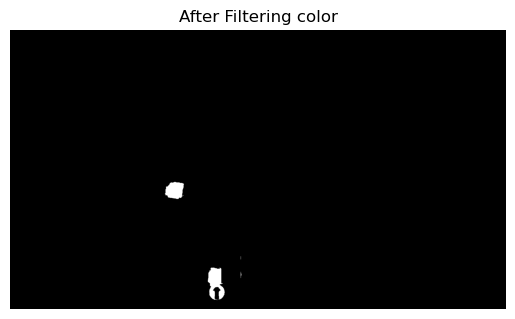

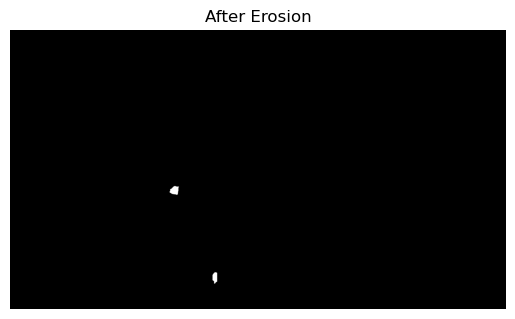

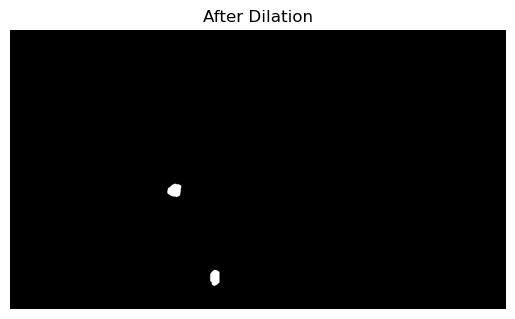

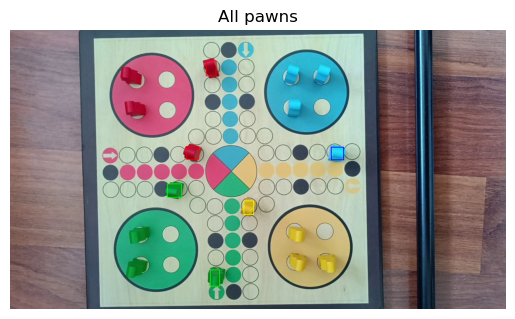

In [17]:
def get_pawn_boxes(sidewalk, color: Color, verbose=False):
    sidewalk_hsv = cv2.cvtColor(sidewalk, cv2.COLOR_BGR2HSV)
        
    ranges = COLOR_RANGES[color]
    mask = np.zeros(sidewalk.shape[:2], dtype=np.uint8)
    for lower, upper in ranges:
        mask |= cv2.inRange(sidewalk_hsv, lower, upper)
    # print(sidewalk_hsv[c], mask[c])
    # imshow(mask)
    if verbose:
        imshow(mask, "After Filtering color")
        
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5),), iterations=8)
    if verbose:
        imshow(mask, "After Erosion")
        
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7),), iterations=3)
    if verbose:
        imshow(mask, "After Dilation")
        
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pawn_boxes = []
    min_pawn_area = (min(frame_width, frame_height) * 0.017)**2
    max_pawn_area = (min(frame_width, frame_height) * 0.10)**2
    # imshow(mask)
    
    for contour in contours:
        mini_mask = np.zeros_like(mask)
        area = cv2.contourArea(contour)
        if min_pawn_area < area < max_pawn_area:
            cv2.drawContours(mini_mask, [contour], -1, (255), -1)
            non_zero_pixels = sidewalk_hsv[mini_mask != 0]
            pawn_boxes.append(cv2.boundingRect(contour))
    
                
    return pawn_boxes   

cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()

board = frame & board_mask
sidewalk = board & ~all_homes_mask & ~all_target_bases_mask

for color in Color:
    pawn_boxes = get_pawn_boxes(sidewalk, color, verbose = True if color == Color.GREEN else False)
    for (x,y,w,h) in pawn_boxes:
        cv2.rectangle(frame, (x, y), (x+w, y+h), BGR[color], 2)

imshow(frame, "All pawns")

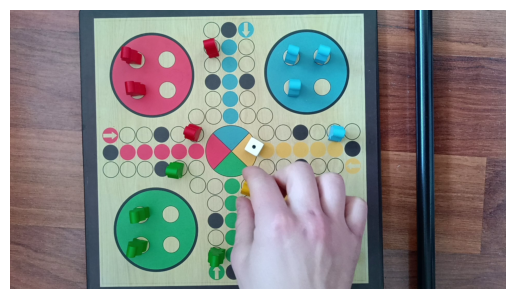

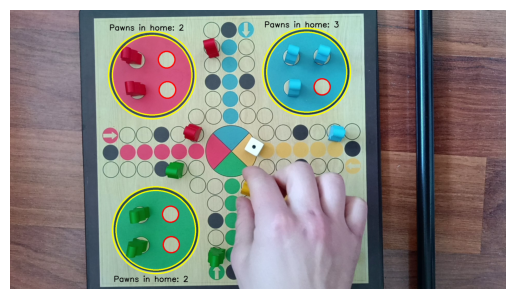

In [18]:
def get_number_of_free_home_places(frame, home, verbose=False):
    home_mask = home["mask"]
    home_radius = home["radius"]
    (cx, cy) = home["center"]

    home_frame =np.zeros_like(frame)
    home_frame[cy-int(1.05*home_radius):cy+int(1.05*home_radius), cx-int(1.05*home_radius):cx+int(1.05*home_radius)] = frame[cy-int(1.05*home_radius):cy+int(1.05*home_radius), cx-int(1.05*home_radius):cx+int(1.05*home_radius)]
    
    home_frame = cv2.cvtColor(home_frame , cv2.COLOR_BGR2GRAY)
    
    home_frame = cv2.GaussianBlur(home_frame, (9,9), 1.5)

    # checking if home is visible
    home_circle = cv2.HoughCircles(
        home_frame,
        method = cv2.HOUGH_GRADIENT_ALT,
        dp = 2,
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 350,
        param2 = 0.8,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.25),
    )

    if home_circle is None:
        return None
    if verbose:
        home_circle = np.uint16(np.around(home_circle))
        for (x,y,r) in home_circle[0, :]:
            cv2.circle(frame, (x,y), r, (0,255,255), 3)

    
    circles = cv2.HoughCircles(
                home_frame,
                method = cv2.HOUGH_GRADIENT_ALT,
                dp = 1.5,
                minDist = int(home_radius*0.4),
                param1 = 400,
                param2 = 0.995,
                minRadius=int(home_radius * 0.125),
                maxRadius=int(home_radius * 0.4),
            )
    
    if circles is None:
        return 0
    
    if verbose:
        circles = np.uint16(np.around(circles))
        for (x,y,r) in circles[0, :]:
            cv2.circle(frame, (x,y), r, (0,0,255), 3)

    return circles.shape[1]

cap.set(cv2.CAP_PROP_POS_FRAMES,100)
ret, frame = cap.read()
imshow(frame)
for color in Color:
    empty_places = get_number_of_free_home_places(frame, homes[color], verbose=True)
    if empty_places is None: # home is not visible
        continue
        
    radius = homes[color]["radius"]
    (x,y) = homes[color]["center"]
    if y > frame_height / 2:
        y_text = y+radius+40
    else:
        y_text = y-radius-10
    
    cv2.putText(frame, f"Pawns in home: {4-empty_places}", (x - radius, y_text), cv2.FONT_HERSHEY_SIMPLEX, 1, thickness=2, color=(0,0,0))

imshow(frame)

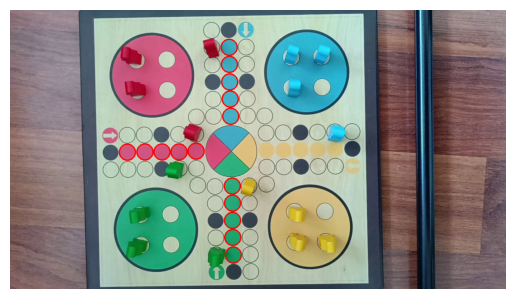

In [19]:
def get_empty_targets(frame, color: Color, verbose=True) -> int:
    frame_gray = cv2.cvtColor(frame & targets[color], cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.GaussianBlur(frame_gray,(7,7),1.5)
    min_radius = int(homes[color]["radius"] * 0.1)
    
    circles = cv2.HoughCircles(
                frame_gray,
                method = cv2.HOUGH_GRADIENT_ALT,
                dp = 1.5,
                minDist = min_radius*2,
                param1 = 300,
                param2 = 0.96,
                minRadius = min_radius,
                maxRadius= 5*min_radius
            )
    
    if circles is None:
        return 0
    if verbose:
        circles = np.uint16(np.around(circles))
        for (x,y,r) in circles[0, :]:
            cv2.circle(frame, (x,y), r, (0,0,255), 3)
    return circles.shape[1]



cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
for color in Color:
    get_empty_targets(frame, color, verbose=True)

imshow(frame)

In [33]:
def render_video(in_path, out_path, seconds=None):
    cap = cv2.VideoCapture(in_path)
    
    if not cap.isOpened():
        raise Exception(f"Could not open {in_path}")

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)

    video_out = cv2.VideoWriter(
        out_path,
        cv2.VideoWriter_fourcc(*"DIVX"),
        fps,
        (frame_width, frame_height),
    )
    processed_frames = 0
    frames_to_generate = np.inf if seconds is None else seconds * fps
    
    home_counters = {
        Color.YELLOW: None,
        Color.RED: None,
        Color.GREEN: None,
        Color.BLUE: None,
    }

    sidewalk_counters = {
        Color.YELLOW: None,
        Color.RED: None,
        Color.GREEN: None,
        Color.BLUE: None,
    }

    target_counters = {
        Color.YELLOW: None,
        Color.RED: None,
        Color.GREEN: None,
        Color.BLUE: None,
    }

    event_str = None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES,0)
    ret, frame = cap.read()
    homes = get_home_masks(frame)
    all_homes_mask = homes[Color.GREEN]["mask"] | homes [Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]
    
    board_mask = get_board_mask_from_homes(frame, homes)
    targets = get_target_bases(frame & board_mask)
    all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]

    sidewalk = frame & board_mask & ~all_target_bases_mask & ~all_homes_mask
    for color in Color:
        pawn_boxes = get_pawn_boxes(sidewalk, color)
          
        filled_targets_no = 5-get_empty_targets(frame, color)
        sidewalk_pawns_no = len(pawn_boxes)
        home_pawns_no = 4 - get_number_of_free_home_places(frame, homes[color])
       
        target_counters[color] = filled_targets_no
        sidewalk_counters[color] = sidewalk_pawns_no
        home_counters[color] = home_pawns_no
        
    ########### MAIN LOOP ########### 
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
 
        sidewalk = frame & board_mask & ~all_target_bases_mask & ~all_homes_mask
        
        if event_str is not None:
            cv2.putText(frame, event_str, (20,60), cv2.FONT_HERSHEY_SIMPLEX, 2, thickness=2, color=(255,255,255))
            event_counter -= 1
            if event_counter == 0:
                event_str = None
            
        for color in Color:
            pawn_boxes = get_pawn_boxes(sidewalk, color)
          
            filled_targets_no = 5-get_empty_targets(frame, color, verbose=True)
            sidewalk_pawns_no = len(pawn_boxes)
            free_home_places = get_number_of_free_home_places(frame, homes[color])

            if filled_targets_no == target_counters[color] + 1 and sidewalk_pawns_no == sidewalk_counters[color] - 1:
                print("Event reached")
                target_counters[color] += 1
                sidewalk_counters[color] -= 1
                event_str = f"EVENT: {color} pawn reached a target"
                event_counter = 60
              
            for (x,y,w,h) in pawn_boxes:
                cv2.rectangle(frame, (x, y), (x+w, y+h), BGR[color], 2)
            
            if free_home_places is not None: # home is visible
                radius = homes[color]["radius"]
                (x,y) = homes[color]["center"]
                if y > frame_height / 2:
                    y_text = y+radius+40
                else:
                    y_text = y-radius-10
                
                cv2.putText(frame, f"Pawns in home: {4-free_home_places}", (x - radius, y_text), cv2.FONT_HERSHEY_SIMPLEX, 1.1, thickness=2, color=(0,0,0))
    
   
                    
        video_out.write(frame)
        processed_frames += 1
        if processed_frames >= frames_to_generate:
            break
            
    cap.release()
    video_out.release()

# Result 

In [37]:
%%time
render_video("videos/easy/gameplay1.mp4", "outs/easy2/gameplay1.avi")
# render_video("videos/easy/gameplay2.mp4", "outs/easy/gameplay2.avi", 4)
# render_video("videos/easy/gameplay3.mp4", "outs/easy/gameplay3.avi",)

Event reached
Event reached
CPU times: user 34min 33s, sys: 23min 40s, total: 58min 13s
Wall time: 21min 3s


In [38]:
!mpv outs/easy2/gameplay1.avi > /dev/null